##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: File API Quickstart

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/File_API.ipynb"><img src="../images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

The Gemini API supports prompting with text, image, and audio data, also known as *multimodal* prompting. You can include text, image,
and audio in your prompts. For small images, you can point the Gemini model
directly to a local file when providing a prompt. For larger text files, images, videos, and audio, upload the files with the [File
API](https://ai.google.dev/api/rest/v1beta/files) before including them in
prompts.

The File API lets you store up to 20GB of files per project, with each file not
exceeding 2GB in size. Files are stored for 48 hours and can be accessed with
your API key for generation within that time period. It is available at no cost in all regions where the [Gemini API is
available](https://ai.google.dev/available_regions).

For information on valid file formats (MIME types) and supported models, see the documentation on
[supported file formats](https://ai.google.dev/tutorials/prompting_with_media#supported_file_formats)
and view the text examples at the end of this guide.

This guide shows how to use the File API to upload a media file and include it in a `GenerateContent` call to the Gemini API. For more information, see the [code
samples](../quickstarts/file-api).


### Install dependencies

In [ ]:
!pip install -U -q "google-generativeai>=0.7.2"

In [ ]:
import google.generativeai as genai
from IPython.display import Image

### Authentication

**Important:** The File API uses API keys for authentication and access. Uploaded files are associated with the API key's cloud project. Unlike other Gemini APIs that use API keys, your API key also grants access data you've uploaded to the File API, so take extra care in keeping your API key secure. For best practices on securing API keys, refer to Google's [documentation](https://support.google.com/googleapi/answer/6310037).

#### Set up your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](./Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

## Upload file

The File API lets you upload a variety of multimodal MIME types, including images and audio formats. The File API handles inputs that can be used to generate content with [`model.generateContent`](https://ai.google.dev/api/rest/v1/models/generateContent) or [`model.streamGenerateContent`](https://ai.google.dev/api/rest/v1/models/streamGenerateContent).

The File API accepts files under 2GB in size and can store up to 20GB of files per project. Files last for 2 days and cannot be downloaded from the API.

First, you will prepare a sample image to upload to the API.

Note: You can also [upload your own files](../examples/Upload_files_to_Colab.ipynb) to use.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  349k  100  349k    0     0  7936k      0 --:--:-- --:--:-- --:--:-- 7936k


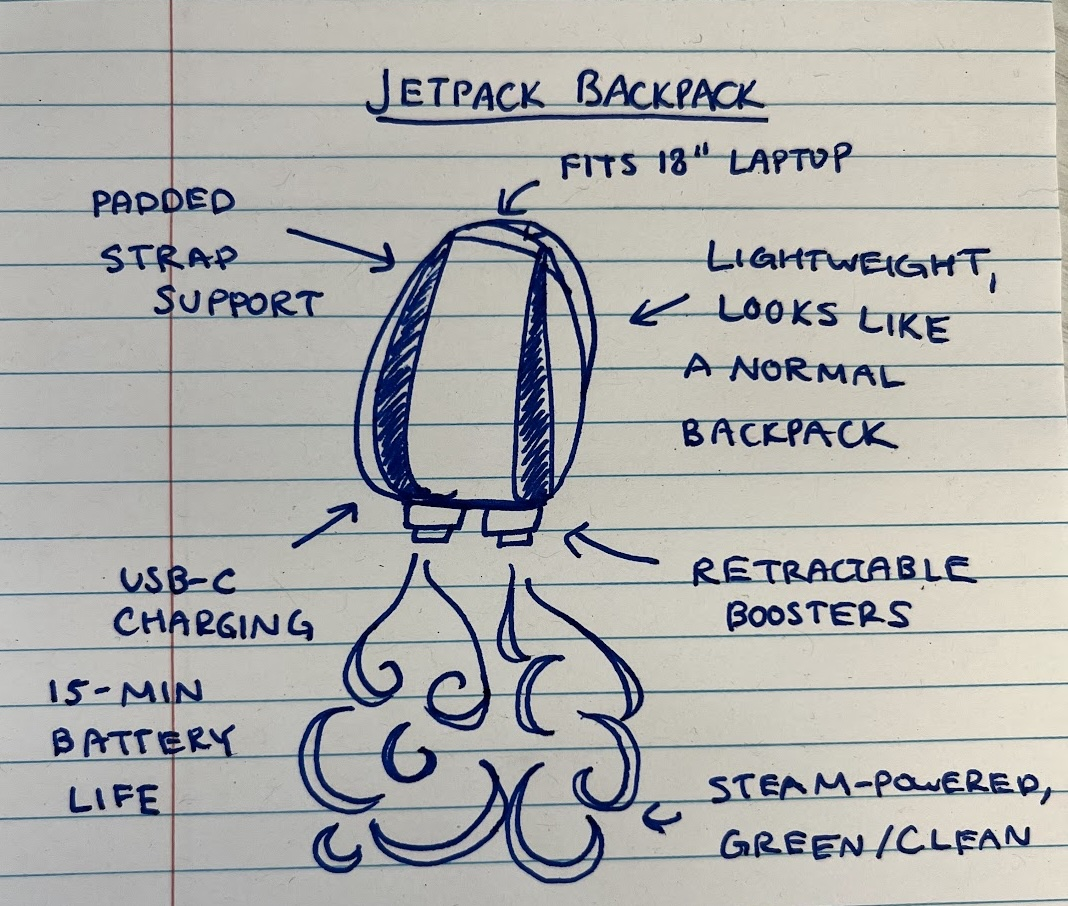

In [2]:
!curl -o image.jpg "https://storage.googleapis.com/generativeai-downloads/images/jetpack.jpg"
Image(filename="image.jpg")

Next, you will upload that file to the File API.

In [3]:
sample_file = genai.upload_file(path="image.jpg", display_name="Sample drawing")

print(f"Uploaded file '{sample_file.display_name}' as: {sample_file.uri}")

Uploaded file 'Sample drawing' as: https://generativelanguage.googleapis.com/v1beta/files/egh2o1so355v


The `response` shows that the File API stored the specified `display_name` for the uploaded file and a `uri` to reference the file in Gemini API calls. Use `response` to track how uploaded files are mapped to URIs.

Depending on your use cases, you could store the URIs in structures such as a `dict` or a database.

## Get file

After uploading the file, you can verify the API has successfully received the files by calling `files.get`.

It lets you get the file metadata that have been uploaded to the File API that are associated with the Cloud project your API key belongs to. Only the `name` (and by extension, the `uri`) are unique. Only use the `displayName` to identify files if you manage uniqueness yourself.

In [4]:
file = genai.get_file(name=sample_file.name)
print(f"Retrieved file '{file.display_name}' as: {sample_file.uri}")

Retrieved file 'Sample drawing' as: https://generativelanguage.googleapis.com/v1beta/files/egh2o1so355v


## Generate content

After uploading the file, you can make `GenerateContent` requests that reference the file by providing the URI. In the Python SDK you can pass the returned object directly.

Here you create a prompt that starts with text and includes the uploaded image.

In [5]:
model = genai.GenerativeModel(model_name="models/gemini-2.0-flash")

response = model.generate_content(
    ["Describe the image with a creative description.", sample_file]
)

print(response.text)

The image is a hand-drawn sketch of a futuristic backpack, labeled "Jetpack Backpack". It looks like a normal backpack, but with retractable boosters that resemble a jetpack. The text describes the features of the backpack, including a padded strap, USB-C charging, a 15-minute battery life, and steam-powered, green, and clean propulsion. This whimsical design suggests a future where transportation is eco-friendly, efficient, and stylish. It's a playful idea that captures the imagination and promises a world where the boundaries between backpack and jetpack blur. 



## Delete files

Files are automatically deleted after 2 days or you can manually delete them using `files.delete()`.

In [6]:
genai.delete_file(sample_file.name)
print(f"Deleted {sample_file.display_name}.")

Deleted Sample drawing.


## Supported text types

As well as supporting media uploads, the File API can be used to embed text files, such as Python code, or Markdown files, into your prompts.

This example shows you how to load a markdown file into a prompt using the File API.

In [7]:
# Download a markdown file and ask a question.

!curl -so contrib.md https://raw.githubusercontent.com/google-gemini/cookbook/main/CONTRIBUTING.md

md_file = genai.upload_file(path="contrib.md", display_name="Contributors guide", mime_type="text/markdown")

model = genai.GenerativeModel(model_name="models/gemini-2.0-flash")
response = model.generate_content(
    [
        "What should I do before I start writing, when following these guidelines?",
        md_file,
    ]
)
print(response.text)

Here's a breakdown of what you should do before you start writing, following the provided guidelines for contributing to the Gemini API Cookbook:

**1. Sign the Contributor License Agreement (CLA):**

* **Purpose:** This agreement grants the project the legal right to use and distribute your contributions. 
* **Action:** Visit [https://cla.developers.google.com/](https://cla.developers.google.com/) and follow the instructions to sign the CLA.
* **Note:** If you've already signed a Google CLA for another project, you may not need to sign it again.

**2. Review the Style Guides:**

* **Technical Writing:** Familiarize yourself with the [technical writing style guide](https://developers.google.com/style), especially the [highlights](https://developers.google.com/style/highlights). This will help you anticipate common feedback and ensure your writing is clear and consistent.
* **Language-Specific:** Check out the relevant [style guide](https://google.github.io/styleguide/) for the programm

Some common text formats are automatically detected, such as `text/x-python`, `text/html` and `text/markdown`. If you are using a file that you know is text, but is not automatically detected by the API as such, you can specify the MIME type as `text/plain` explicitly.

In [8]:
# Download some C++ code and force the MIME as text when uploading.

!curl -so gemma.cpp https://raw.githubusercontent.com/google/gemma.cpp/main/examples/hello_world/run.cc

cpp_file = genai.upload_file(
    path="gemma.cpp", display_name="gemma.cpp", mime_type="text/plain"
)

model = genai.GenerativeModel(model_name="models/gemini-2.0-flash")
response = model.generate_content(["What does this program do?", cpp_file])
print(response.text)

This program demonstrates how to use the Gemma library for text generation. Here's a breakdown:

**1. Header Files and Initialization:**

* **`#include <iostream>`:**  Includes standard input/output stream facilities for printing to the console.
* **`#include "third_party/gemma_cpp/gemma.h"`:**  Includes the Gemma C++ library.
* **`#include "util/app.h"`:**  Includes application-related utilities, likely defining `LoaderArgs` for handling command-line arguments.
* **`#include "hwy/contrib/thread_pool/thread_pool.h"`:**  Includes the HWY library for multi-threading.
* **`#include "util/args.h"`:**  Includes utilities for parsing command-line arguments.

**2. `tokenize` Function:**

* **Input:**
    * `prompt_string`: The text prompt you want to use for generation.
    * `tokenizer`: A GemmaTokenizer object for converting text to integers (tokens).
* **Output:**
    * `tokens`: A vector of integers representing the tokenized input prompt.
* **Purpose:** 
    * Prepares the input prompt b

## Next Steps
### Useful API references:

For more information about the File API, check its [API reference](https://ai.google.dev/api/files). You will also find more code samples [in this folder](../quickstarts/file-api).

### Related examples

Check those examples using the File API to give you more ideas on how to use that very useful feature:
* Share [Voice memos](../examples/Voice_memos.ipynb) with Gemini API and brainstorm ideas
* Analyze videos to [classify](../examples/Analyze_a_Video_Classification.ipynb) or [summarize](../examples/Analyze_a_Video_Summarization.ipynb) them

### Continue your discovery of the Gemini API

If you're not already familiar with it, learn how [tokens are counted](../quickstarts/Counting_Tokens.ipynb). Then check how to use the File API to use [Audio](../quickstarts/Audio.ipynb) or [Video](../quickstarts/Video.ipynb) files with the Gemini API.
